# Bridging the gap: model mixing with Gaussian processes

## Alexandra Semposki

### Date: 29 October 2021

## GPs with scikit learn

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mixing import Mixing, Switching, Models
from discrepancy import Discrepancy
from gaussprocess import GP

matplotlib.rcParams.update({
   'font.family': 'serif',
   'text.usetex': True,
})

Welcome to the BMM sandbox! Here you get to play!
Select a dpi for the figure.100


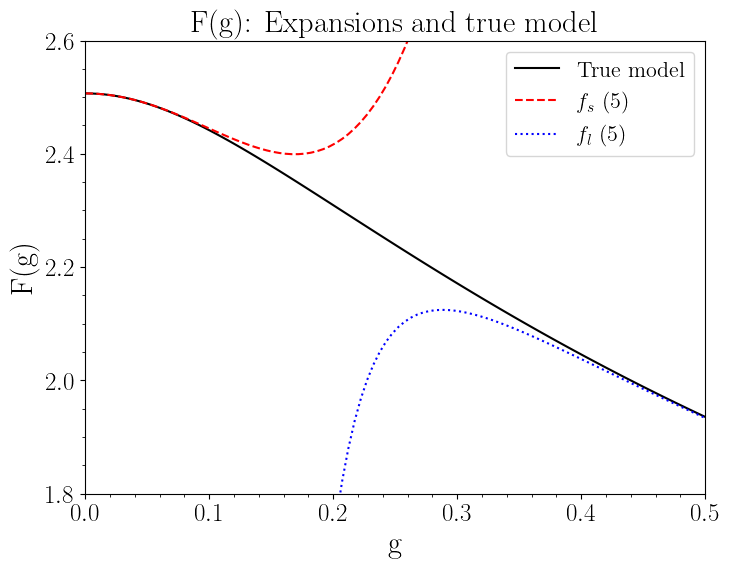

Would you like to save this figure? (yes/no)no


In [2]:
#first we need to see which models we want to mix
models = Mixing()
g = np.linspace(1e-6, 0.5, 100)
low = np.array([5])
high = np.array([5])
models.plot_models(g, low, high)

In [3]:
#begin by calling the GP class just to see if it works
new = GP(g)

Initializing standard Constant * RBF kernel.


After loading the GP we wish to get some data from the models and try to emulate between the two. Let's take some data and plot it.

Which error model do you want to use? (uninformative/informative)informative
Small-g expansion: error will be on the order of g^6.
[ 0.          0.         -0.4699928   0.          0.51405463  0.        ]
Large-g expansion: error will be of the order g^6.
[ 1.81280495 -1.08599728  0.90640248 -0.81449796  0.7553354  -0.71268571]
Optimized parameters: 1.09**2, RBF(length_scale=0.353)
Set a dpi for the figure.100


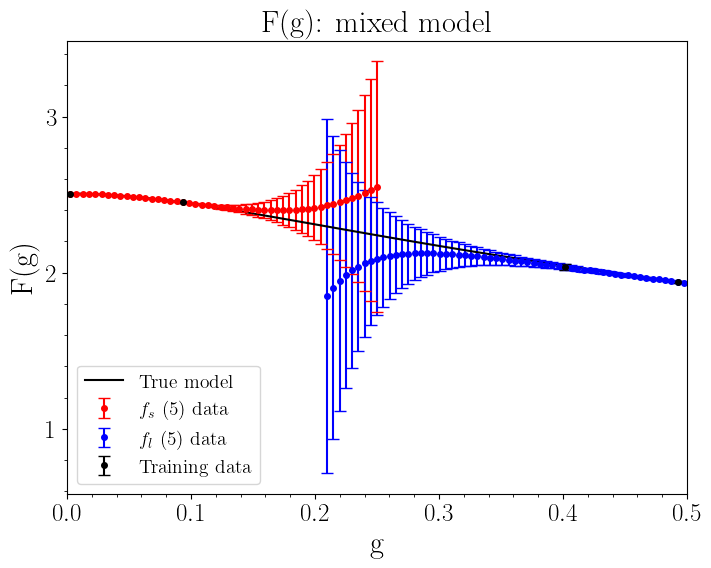

Would you like to save this figure? (yes/no)no


In [4]:
trained = new.training(low, high, error=True)

Now we use the training results to predict across the gap with new points. 

Set a dpi for the figure.200


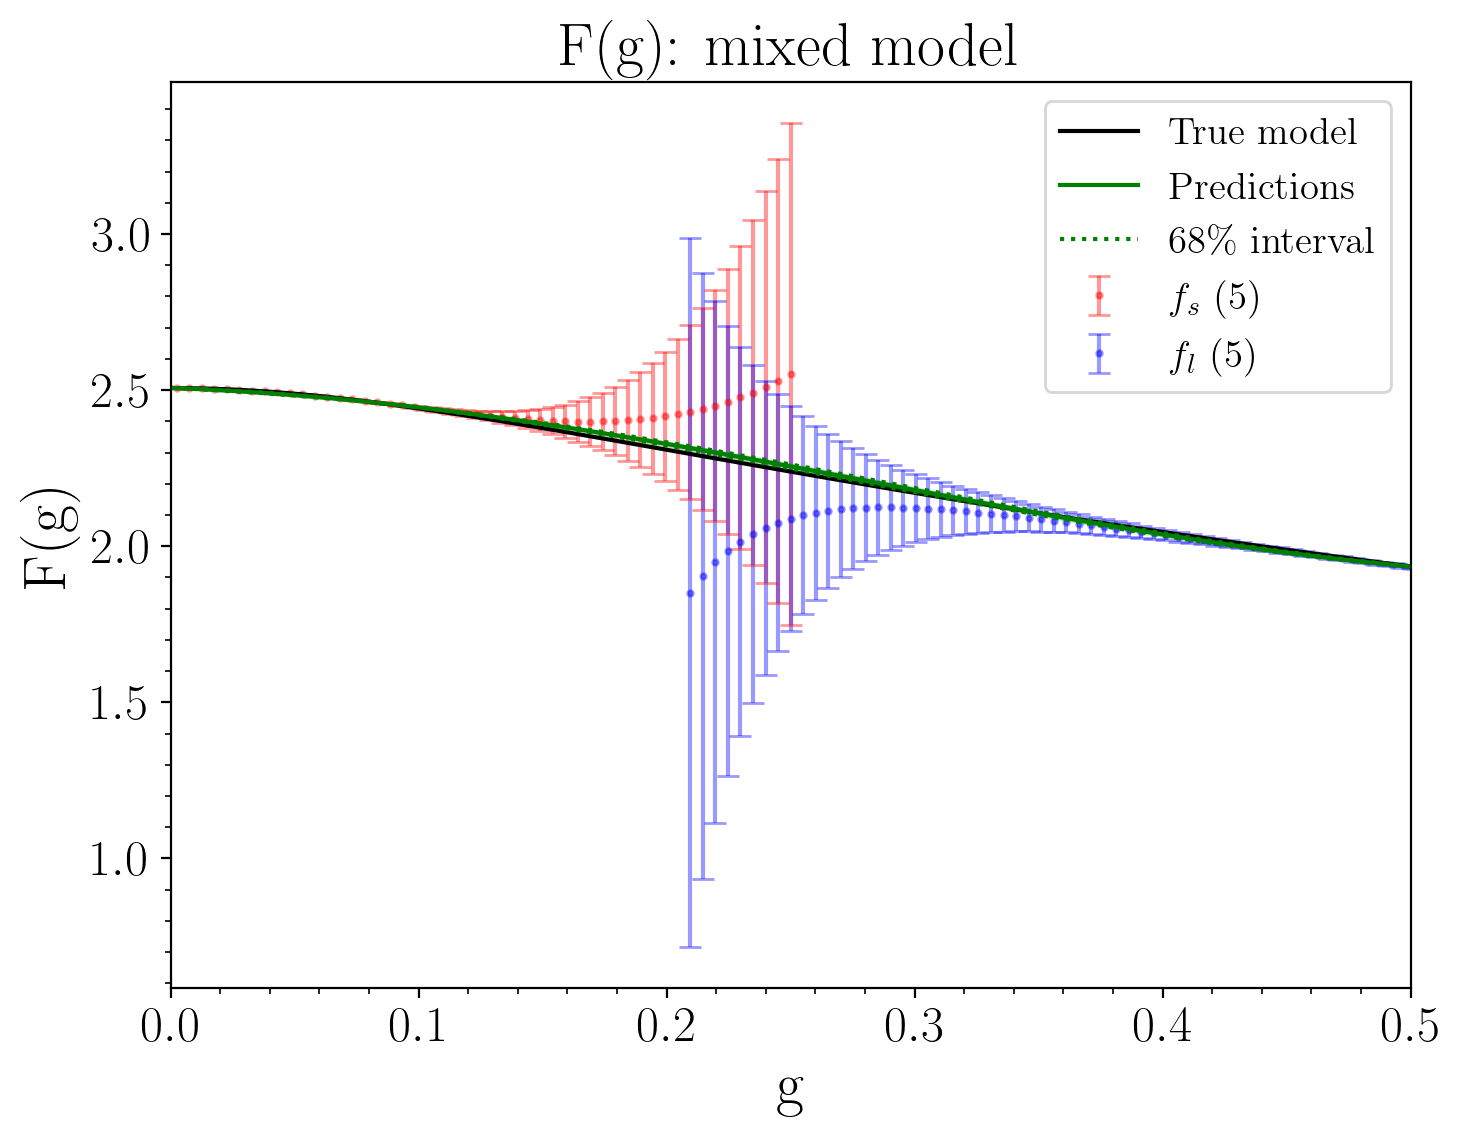

Would you like to save this figure? (yes/no)no
[0.00014323 0.00013369 0.00037312 0.00057632 0.00074464 0.00087947
 0.00098224 0.00105446 0.00109772 0.0011137  0.00110423 0.00107132
 0.00101731 0.00094509 0.00085846 0.00076298 0.00066751 0.00058687
 0.00054373 0.00056176 0.00064766 0.00078812 0.00096575 0.00116799
 0.00138696 0.00161762 0.00185648 0.00210092 0.00234885 0.00259848
 0.00284825 0.00309674 0.00334265 0.00358477 0.00382199 0.00405327
 0.00427762 0.00449416 0.00470203 0.00490047 0.00508878 0.00526632
 0.00543252 0.00558687 0.00572893 0.00585835 0.00597482 0.00607811
 0.00616807 0.0062446  0.00630767 0.00635735 0.00639373 0.006417
 0.00642741 0.00642528 0.00641097 0.00638492 0.00634762 0.00629962
 0.00624151 0.00617395 0.0060976  0.00601319 0.00592146 0.00582317
 0.0057191  0.00561    0.00549665 0.00537975 0.00526001 0.00513805
 0.00501443 0.00488962 0.00476398 0.00463776 0.00451107 0.00438385
 0.00425593 0.00412693 0.00399635 0.00386349 0.00372754 0.00358751
 0.00344235 0.003

In [5]:
mean, var = new.validate(trained, low, high, interval=68)
print(var)

In [6]:
#call the Discrepancy plotting function for 3 models
newplot = Discrepancy()
print(mean)
print(np.shape(mean))
print(mean.reshape(-1,1).T)

[2.50739981 2.50572181 2.50388766 2.50189673 2.49974854 2.49744273
 2.49497909 2.49235754 2.48957815 2.48664112 2.48354679 2.48029566
 2.47688835 2.47332563 2.46960844 2.46573783 2.46171502 2.45754135
 2.45321832 2.44874758 2.44413091 2.43937023 2.43446762 2.42942527
 2.42424553 2.41893088 2.41348394 2.40790744 2.40220427 2.39637743
 2.39043004 2.38436536 2.37818676 2.37189773 2.36550185 2.35900285
 2.35240453 2.34571081 2.33892571 2.33205333 2.32509788 2.31806364
 2.31095497 2.30377633 2.29653222 2.28922723 2.28186601 2.27445326
 2.26699375 2.25949227 2.25195368 2.24438287 2.23678475 2.22916428
 2.22152642 2.21387616 2.20621849 2.19855843 2.19090098 2.18325114
 2.17561389 2.16799423 2.16039709 2.15282741 2.1452901  2.13779001
 2.13033196 2.12292074 2.11556106 2.10825759 2.10101495 2.09383768
 2.08673025 2.07969705 2.07274241 2.06587057 2.05908567 2.05239177
 2.04579284 2.03929273 2.03289522 2.02660395 2.02042247 2.01435422
 2.00840252 2.00257056 1.99686143 1.99127809 1.98582336 1.9804

Set a dpi for the figure.200

x-limits (enter "auto" if unknown): auto

y-limits (enter "auto" if unknown): auto
Which error model do you want to use, uninformative or informative?informative
Small-g expansion: error will be on the order of g^6.
[ 0.          0.         -0.4699928   0.          0.51405463  0.        ]
Large-g expansion: error will be of the order g^6.
[ 1.81280495 -1.08599728  0.90640248 -0.81449796  0.7553354  -0.71268571]
Which interval do you want to use: 68 or 95?68
(1, 100)


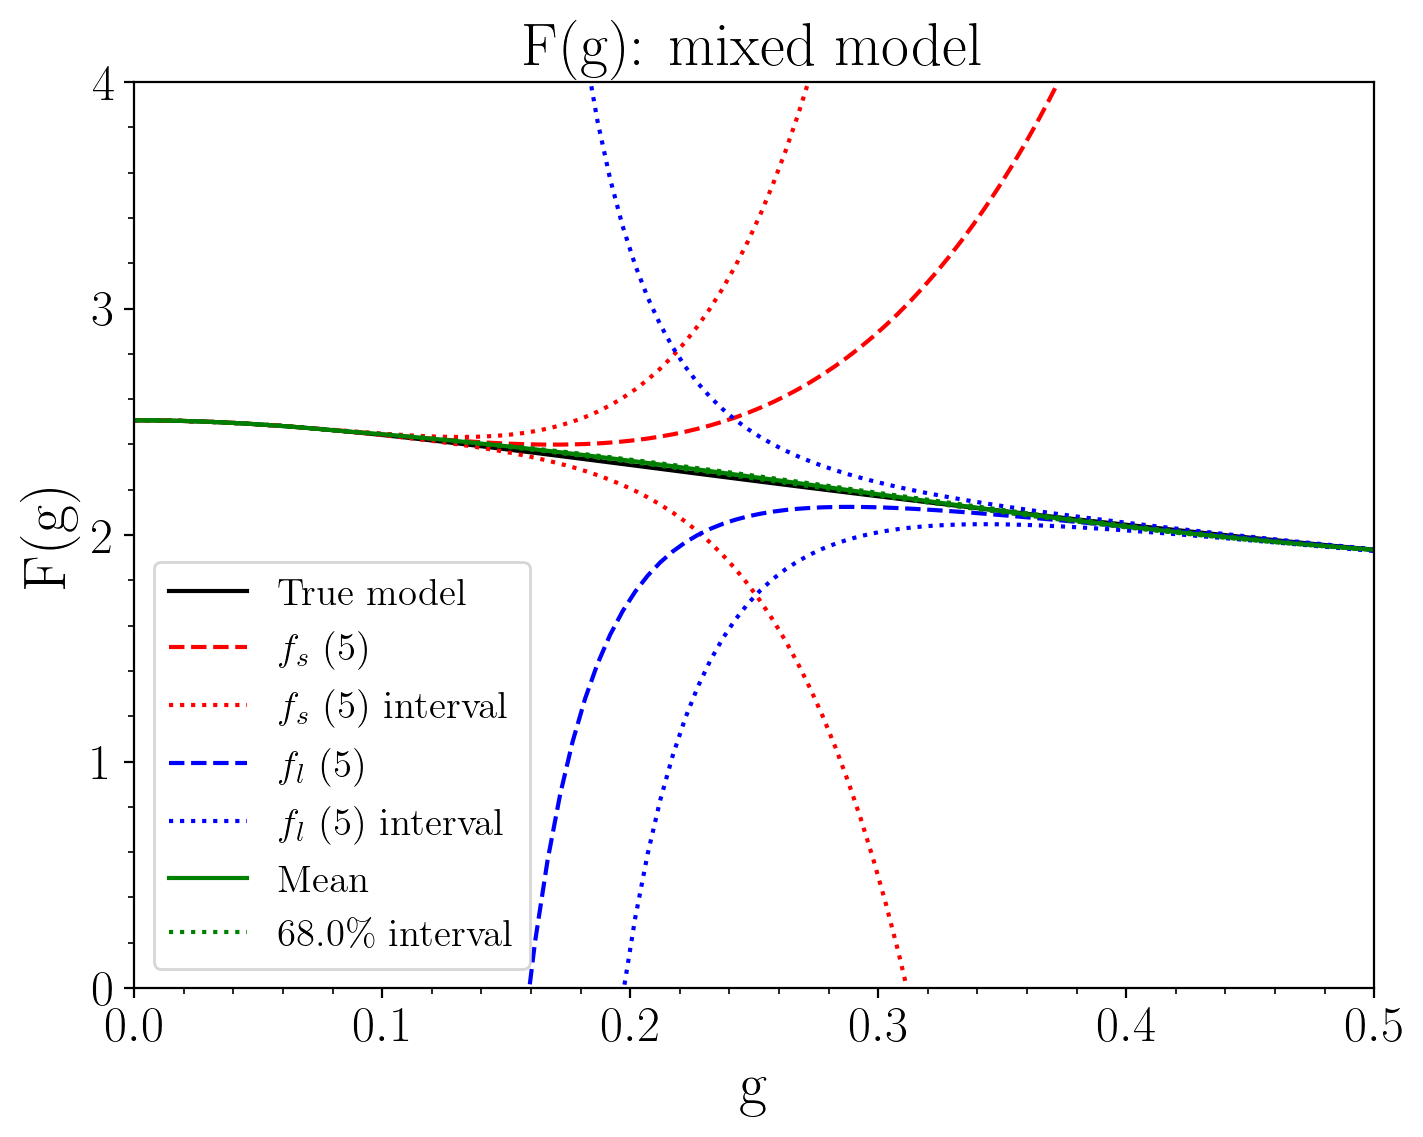

Would you like to save this figure? (yes/no)no


In [7]:
g_plot = np.linspace(1e-6,0.5,100)
newplot.plot_mix(g_plot, low, high, plot_fdagger=True, GP_mean=mean, GP_var=np.square(var), next_order=False)